In [1]:
import bcolz
import numpy as np
import os
import glob
import threading
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed, ThreadPoolExecutor 
from PIL import Image
from vgg16 import Vgg16

Using TensorFlow backend.


We will resize our images to 224 x 224

In [2]:
new_size = 224
# rootdir = os.getcwd()
# DANGER DANGER DANGER
# THIS WILL COMPLETELY EMPTY YOUR DIRECTORY TO MAKE ITS OWN FOLDERS
# KILLED MY TRAINING DATA AND DELETED MY JUPYTER NOTEBOOK
rootdir = '/home/drsnuggles/bcolz/data'
arr = bcolz.carray(np.empty((0, new_size, new_size, 3), 'float32'), 
                   chunklen=16, mode='w', rootdir=rootdir)

# chunklen: the default size of the block that is returned from rootdir's data. 
#           the higher the faster, but the more memory it uses


In [3]:
arr

carray((0, 224, 224, 3), float32)
  nbytes := 0; cbytes := 9.19 MB; ratio: 0.00
  cparams := cparams(clevel=5, shuffle=1, cname='lz4', quantize=0)
  chunklen := 16; chunksize: 9633792; blocksize: 0
  rootdir := '/home/drsnuggles/bcolz/data'
  mode    := 'w'
[]

In [4]:
np.empty((0, new_size, new_size, 3), 'float32')

array([], shape=(0, 224, 224, 3), dtype=float32)

In [5]:
%%bash
tree /home/drsnuggles/bcolz/data

/home/drsnuggles/bcolz/data
├── __attrs__
├── data
└── meta
    ├── sizes
    └── storage

2 directories, 3 files


In [6]:
tl = threading.local()
#A class that represents thread-local data. Thread-local data are data whose values are thread specific.

tl.place = np.zeros((new_size,new_size,3), 'uint8')
tl.place.shape

(224, 224, 3)

In [7]:


def resize_img(i):
    img = Image.open(fnames[i])
    s = np.array(img).shape
    
    if len(s)!=3 or s[2]!=3: return

    shortest = min(img.width,img.height)
    
    resized = np.round(np.multiply(new_size/shortest, img.size)).astype(int)    
    return img.resize(resized, Image.BILINEAR)


def get_slice(p, n):
    return slice( (p-n+1)//2, p-(p-n)//2 )

def app_img(r):
    """ Replaces our temporary all-zeroes array with slices of the actual data
    if no data, put 0. in there"""
    # it's necessary to make temporary sub arrays so we can run separate jobs at once
    
    tl.place[:] = (np.array(r)[get_slice(r.size[1],new_size), get_slice(r.size[0],new_size)] if r else 0.)
    # append to our big array, i think this locks the array
    arr.append(tl.place)
    


Now load some training data

In [8]:
fnames = glob.glob('/home/drsnuggles/bcolz/train/*/*.jpg')

In [9]:
fnames[0]

'/home/drsnuggles/bcolz/train/cat/cat.20.jpg'

In [10]:
n = len(fnames)
n

200

In [11]:
# Parallel version
step=6400

# tqdm is just there to make a status bar
for i in tqdm(range(0, n, step)):

    with ThreadPoolExecutor(max_workers=1) as execr:
        res = execr.map(resize_img, range(i, min(i+step, n)))
        for r in res:
            app_img(r)
    arr.flush()


100%|██████████| 1/1 [00:00<00:00,  1.16it/s]


ThreadPoolExecutor(max_workers=1) runs roughly 1 iteration/s,ThreadPoolExecutor(max_workers=12) runs 2/s, wow


In [12]:
arr

carray((200, 224, 224, 3), float32)
  nbytes := 114.84 MB; cbytes := 39.99 MB; ratio: 2.87
  cparams := cparams(clevel=5, shuffle=1, cname='lz4', quantize=0)
  chunklen := 16; chunksize: 9633792; blocksize: 32768
  rootdir := '/home/drsnuggles/bcolz/data'
  mode    := 'w'
[[[[ 106.  100.   97.]
   [ 109.  100.   96.]
   [ 109.  100.   96.]
   ..., 
   [ 117.  121.  122.]
   [ 115.  119.  120.]
   [ 113.  117.  118.]]

  [[ 108.  104.  102.]
   [ 108.  104.  103.]
   [ 108.  104.  103.]
   ..., 
   [ 116.  120.  121.]
   [ 113.  117.  118.]
   [ 112.  116.  117.]]

  [[ 108.  107.  105.]
   [ 108.  108.  109.]
   [ 108.  109.  110.]
   ..., 
   [ 115.  119.  120.]
   [ 113.  117.  118.]
   [ 113.  117.  118.]]

  ..., 
  [[ 194.  160.  105.]
   [ 194.  161.  108.]
   [ 197.  164.  111.]
   ..., 
   [ 138.  140.  139.]
   [ 139.  141.  140.]
   [ 140.  142.  141.]]

  [[ 192.  157.  103.]
   [ 191.  158.  105.]
   [ 191.  158.  105.]
   ..., 
   [ 137.  139.  138.]
   [ 136.  138.  137.]

In [13]:
# automatically saved - let's open again!
arr = bcolz.open('/home/drsnuggles/bcolz/data/')

In [14]:
arr

carray((200, 224, 224, 3), float32)
  nbytes := 114.84 MB; cbytes := 39.99 MB; ratio: 2.87
  cparams := cparams(clevel=5, shuffle=1, cname='lz4', quantize=0)
  chunklen := 16; chunksize: 9633792; blocksize: 32768
  rootdir := '/home/drsnuggles/bcolz/data/'
  mode    := 'a'
[[[[ 106.  100.   97.]
   [ 109.  100.   96.]
   [ 109.  100.   96.]
   ..., 
   [ 117.  121.  122.]
   [ 115.  119.  120.]
   [ 113.  117.  118.]]

  [[ 108.  104.  102.]
   [ 108.  104.  103.]
   [ 108.  104.  103.]
   ..., 
   [ 116.  120.  121.]
   [ 113.  117.  118.]
   [ 112.  116.  117.]]

  [[ 108.  107.  105.]
   [ 108.  108.  109.]
   [ 108.  109.  110.]
   ..., 
   [ 115.  119.  120.]
   [ 113.  117.  118.]
   [ 113.  117.  118.]]

  ..., 
  [[ 194.  160.  105.]
   [ 194.  161.  108.]
   [ 197.  164.  111.]
   ..., 
   [ 138.  140.  139.]
   [ 139.  141.  140.]
   [ 140.  142.  141.]]

  [[ 192.  157.  103.]
   [ 191.  158.  105.]
   [ 191.  158.  105.]
   ..., 
   [ 137.  139.  138.]
   [ 136.  138.  137.

In [15]:
%%bash
echo "Size bcolz"
du -sh /home/drsnuggles/bcolz/data/
echo "Size raw data"
du -sh /home/drsnuggles/bcolz/train/

Size bcolz
33M	/home/drsnuggles/bcolz/data/
Size raw data
4.7M	/home/drsnuggles/bcolz/train/


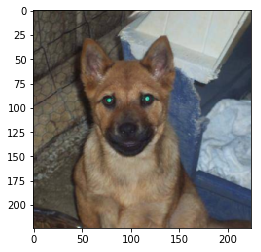

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(arr[-1].astype('uint8'))

Doggie!

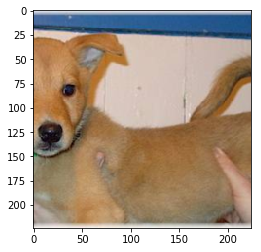

In [17]:
plt.imshow(arr[-2].astype('uint8'))

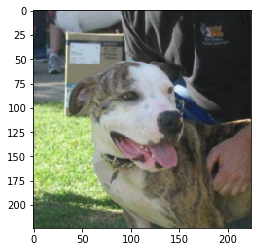

In [18]:
plt.imshow(arr[-100].astype('uint8'))

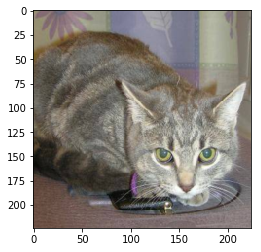

In [19]:
plt.imshow(arr[99].astype('uint8'))

So the first 100 pictures are cats, the last 100 pictures are doggos

In [20]:
print('Pixel 0x0 has these colors:', arr[99][0][0])

Pixel 0x0 has these colors: [ 150.  145.  107.]


Now we need to make some labels, either from the filenames or from the order in the array. let's be lazy. Need a 2 dimensional array of length 200, 1 means cat, 0 means dog

In [21]:
labels = np.concatenate((np.array(100*[[1,0]]), np.array(100*[[0,1]])))

In [22]:
import h5py
vgg = Vgg16()

In [29]:
imgs = arr[:4]
imgs.shape

(4, 224, 224, 3)

In [30]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

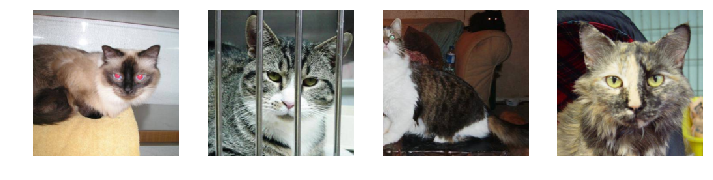

In [31]:
plots(imgs)

Annoyance: this vgg16 implementation wants the shape to be (4, 3, 224, 224)

In [32]:
imgs = np.swapaxes(imgs, 1, 3)

Let's predict some cats!

In [33]:
vgg.predict(imgs, True)

(array([ 0.99970573,  0.55345106,  0.21275382,  0.31902987], dtype=float32),
 array([284, 285, 264, 281]),
 ['Siamese_cat', 'Egyptian_cat', 'Cardigan', 'tabby'])


    preds (np.array) : Highest confidence value of the predictions for each image.
    idxs (np.ndarray): Class index of the predictions with the max confidence.
    classes (list)   : Class labels of the predictions with the max confidence.


Let's predict some dogs!

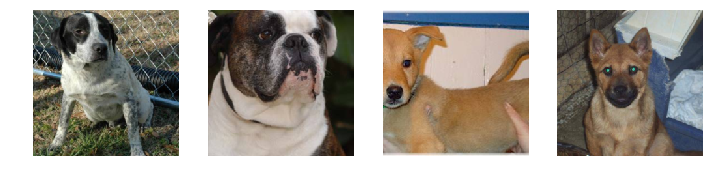

In [34]:
imgs = arr[-4:]
plots(imgs)

In [35]:

imgs = np.swapaxes(imgs, 1, 3)
vgg.predict(imgs, True)

(array([ 0.35979265,  0.22735943,  0.47306991,  0.16224435], dtype=float32),
 array([246, 242, 253, 237]),
 ['Great_Dane', 'boxer', 'basenji', 'miniature_pinscher'])